In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# 2. LSTM Autoencoder Model
class StatefulLSTM_Autoencoder(nn.Module):
    def __init__(self, num_channels, hidden_size, num_layers, feature_dim=10):
        super(StatefulLSTM_Autoencoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Encoder
        self.encoder = nn.LSTM(input_size=num_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, feature_dim)

        # Decoder
        self.fc2 = nn.Linear(feature_dim, hidden_size)
        self.decoder = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, num_channels)

    def init_hidden(self, batch_size, device):
        """Create initial hidden state tensors (h_0, c_0)"""
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

    def forward(self, x, encoder_hidden, decoder_hidden):
        x = x.permute(0, 2, 1)  # (batch_size, num_samples, num_channels)

        # Encoder forward pass with provided hidden state
        _, encoder_hidden = self.encoder(x, encoder_hidden)
        # print("Encoder hidden shape:", [h.shape for h in encoder_hidden])  # Print shapes of h_0 and c_0

        # Feature bottleneck
        features = self.fc1(encoder_hidden[0][-1])  # Last layer's hidden state
        # print(features.shape)
        expanded_features = self.fc2(features).unsqueeze(1).repeat(1, x.shape[1], 1)
        # print(expanded_features.shape)
        # print("Decoder hidden shape:", [h.shape for h in decoder_hidden])  # Print shapes of h_0 and c_0

        # Decoder forward pass with provided hidden state
        decoded_output, decoder_hidden = self.decoder(expanded_features, decoder_hidden)
        decoded_output = self.fc_out(decoded_output)

        # Detach hidden states to prevent backpropagation across batches
        encoder_hidden = (encoder_hidden[0].detach(), encoder_hidden[1].detach())
        decoder_hidden = (decoder_hidden[0].detach(), decoder_hidden[1].detach())

        return decoded_output.permute(0, 2, 1), features, encoder_hidden, decoder_hidden  # (batch_size, num_channels, num_samples)

In [4]:
class DecoderOnly(nn.Module):
    def __init__(self, hidden_size, num_layers, feature_dim, num_channels):
        super(DecoderOnly, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.fc2 = nn.Linear(feature_dim, hidden_size)  # Map features to hidden size
        self.decoder = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, num_channels)

    def init_hidden(self, batch_size, device):
        """Create initial hidden state tensors (h_0, c_0)"""
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

    def forward(self, features, seq_length, decoder_hidden):
        expanded_features = self.fc2(features).unsqueeze(1).repeat(1, seq_length, 1)  
        
        # Decoder forward pass
        decoded_output, decoder_hidden = self.decoder(expanded_features, decoder_hidden)
        decoded_output = self.fc_out(decoded_output)

        # Detach hidden state to prevent gradient tracking
        decoder_hidden = (decoder_hidden[0].detach(), decoder_hidden[1].detach())

        return decoded_output.permute(0, 2, 1), decoder_hidden  # (batch_size, num_channels, num_samples)

In [5]:
# Load model function
def load_model(filepath, num_channels, hidden_size, num_layers, feature_dim):
    model = StatefulLSTM_Autoencoder(num_channels, hidden_size, num_layers, feature_dim)
    model.load_state_dict(torch.load(filepath))
    model.eval()  # Set the model to evaluation mode
    return model

In [6]:
def load_decoder(autoencoder, num_channels, hidden_size, num_layers, feature_dim):
    # Extract decoder from the trained model
    decoder = DecoderOnly(
        hidden_size=autoencoder.hidden_size,
        num_layers=autoencoder.num_layers,
        feature_dim=feature_dim,
        num_channels=num_channels
    )

    print(autoencoder.num_layers)
    print(autoencoder.hidden_size)

    # decoder.load_state_dict({
    #     "fc2.weight": autoencoder.fc2.weight,
    #     "fc2.bias": autoencoder.fc2.bias,
    #     "decoder.weight_ih_l0": autoencoder.decoder.weight_ih_l0,
    #     "decoder.weight_hh_l0": autoencoder.decoder.weight_hh_l0,
    #     "decoder.bias_ih_l0": autoencoder.decoder.bias_ih_l0,
    #     "decoder.bias_hh_l0": autoencoder.decoder.bias_hh_l0,
    #     "fc_out.weight": autoencoder.fc_out.weight,
    #     "fc_out.bias": autoencoder.fc_out.bias,
    # })

    # Create a state dictionary for the decoder
    decoder_state_dict = {}

    # Copy fc2 and fc_out weights
    decoder_state_dict["fc2.weight"] = autoencoder.fc2.weight
    decoder_state_dict["fc2.bias"] = autoencoder.fc2.bias
    decoder_state_dict["fc_out.weight"] = autoencoder.fc_out.weight
    decoder_state_dict["fc_out.bias"] = autoencoder.fc_out.bias

    # Copy all LSTM layer weights dynamically
    for layer in range(autoencoder.num_layers):
        decoder_state_dict[f"decoder.weight_ih_l{layer}"] = autoencoder.decoder.state_dict()[f"weight_ih_l{layer}"]
        decoder_state_dict[f"decoder.weight_hh_l{layer}"] = autoencoder.decoder.state_dict()[f"weight_hh_l{layer}"]
        decoder_state_dict[f"decoder.bias_ih_l{layer}"] = autoencoder.decoder.state_dict()[f"bias_ih_l{layer}"]
        decoder_state_dict[f"decoder.bias_hh_l{layer}"] = autoencoder.decoder.state_dict()[f"bias_hh_l{layer}"]

    # Load the updated decoder state dictionary
    decoder.load_state_dict(decoder_state_dict)


    decoder.eval()
    return decoder

In [7]:
# Save reconstructed data to HDF5
def save_data(filepath, data):
    with h5py.File(filepath, 'w') as f:
        f.create_dataset('reconstructed_data', data=data)
    print(f"Reconstructed data saved to {filepath}")

In [8]:
# 5. Load Data
def load_data(file_path, dataset):
    with h5py.File(file_path, 'r') as f:
        X = f[dataset][:]
    data = torch.from_numpy(X).float()  # Convert to PyTorch tensor
    return data

In [9]:
# Inference function
def run_decoder(model, data_loader, seq_len):
    model.to(device)
    all_reconstructed = []

    with torch.no_grad():
        # Initialize hidden states
        batch_size = next(iter(data_loader))[0].size(0)
        # encoder_hidden = model.init_hidden(batch_size, device)
        decoder_hidden = model.init_hidden(batch_size, device)

        for inputs in data_loader:
            inputs = inputs[0].to(device)
            # decoded, features, encoder_hidden, decoder_hidden = model(inputs, encoder_hidden, decoder_hidden)
            decoded, decoder_hidden = model(inputs, seq_len, decoder_hidden)
            all_reconstructed.append(decoded.cpu().numpy())  # Store the reconstructed output
            # all_features.append(features.cpu().numpy())  # Store the reconstructed output


    return np.concatenate(all_reconstructed, axis=0) # Combine all outputs

In [72]:
# Load Data
def load_conditions(file_path):
    cond = np.load(file_path)['arr_0']

    # Processing input
    # c_rs = cond.reshape(-1, 12, cond.shape[1])

    c = torch.from_numpy(cond).float()
    print(f'Conditions Shape: {c.shape}')
    return c

In [73]:
condition_path = r'D:\Ali_Thesis\synthetic_data_generation\Data\Process_canada_data\Activities_probs\trial_3_scipy_resample\P13_conditions_onehot.npz'
conditions = load_conditions(condition_path)

Conditions Shape: torch.Size([417840, 7])


In [74]:
cond = conditions[:, :6]
cond[0]

tensor([0., 0., 0., 0., 1., 0.])

In [75]:
cond = cond[:417792]
cond.shape

torch.Size([417792, 6])

In [16]:
# Main execution for inference
# Load the data
file_path = r"D:\Ali_Thesis\synthetic_data_generation\Data\Process_canada_data\P13_5_sec_30hz_sequences_sensor_data.h5"
data = load_data(file_path, 'data')
data.shape

torch.Size([417840, 6, 150])

In [17]:
data = data[:417792]
data.shape

torch.Size([417792, 6, 150])

In [18]:
featrures = np.load(r'D:\Ali_Thesis\synthetic_data_generation\Data\Process_canada_data\features_extraction\trial_12\features.npz')['arr_0']
scenario_Ftrs = load_data(r'D:\Ali_Thesis\synthetic_data_generation\c_lstm_decoder_16\reconstructed_features.h5', 'reconstructed_features')

In [19]:
seq_len = 150
num_channels = 6
Ftrs = torch.from_numpy(featrures).float()

In [20]:
Ftrs = Ftrs[:417792]

In [21]:
scenario_Ftrs = scenario_Ftrs.reshape(-1, 10)

In [22]:
Ftrs.shape, scenario_Ftrs.shape

(torch.Size([417792, 10]), torch.Size([417792, 10]))

In [23]:
# Define batch size (can be same as used during training)
batch_size = 16  # Or any suitable batch size for inference
data_loader = DataLoader(TensorDataset(Ftrs), batch_size=batch_size, shuffle=False, drop_last=False)
scenario_data_loader = DataLoader(TensorDataset(scenario_Ftrs), batch_size=batch_size, shuffle=False, drop_last=False)

In [24]:
# Load the trained model
model_path = r"D:\Ali_Thesis\synthetic_data_generation\Data\Process_canada_data\features_extraction\trial_12\lstm_autoencoder.pth"
model = load_model(model_path, num_channels, hidden_size=64, num_layers=2, feature_dim=10)
decoder = load_decoder(model, num_channels, hidden_size=64, num_layers=2, feature_dim=10)

2
64


In [25]:
# Run inference
# reconstructed_data, features = run_inference(model, data_loader)
reconstructed_data = run_decoder(decoder, data_loader, seq_len)
reconstructed_scenario_data = run_decoder(decoder, scenario_data_loader, seq_len)

reconstructed_data = torch.from_numpy(reconstructed_data).float()
reconstructed_scenario_data = torch.from_numpy(reconstructed_scenario_data).float()

# # Save the reconstructed data to an HDF5 file
# save_data(r'D:\Ali_Thesis\synthetic_data_generation\Data\Process_canada_data\features_extraction\reconstructed_data_from_decoder.h5', reconstructed_data)
# np.savez_compressed(r'D:\Ali_Thesis\synthetic_data_generation\Data\Process_canada_data\features_extraction\features.npz', features)

# Optionally: save or visualize the reconstructed data
print("Reconstructed Data Shape:", reconstructed_data.shape)
print("Reconstructed Scenario Data Shape:", reconstructed_scenario_data.shape)
# print("Reconstructed Data Shape:", features.shape)

Reconstructed Data Shape: torch.Size([417792, 6, 150])
Reconstructed Scenario Data Shape: torch.Size([417792, 6, 150])


In [26]:
def order_data(X, order):
    # Reorder using NumPy indexing
    X_reorderd = X[:, order, :]

    # Print shape to confirm it remains unchanged
    print("Original shape:", X.shape)
    print("Standardized and reordered shape:", X_reorderd.shape)
    return X_reorderd

In [27]:
order = [1, 2, 3, 4, 5, 0]  # Acc_X, Acc_y, Acc_z, BvP, TEMP, EDA
data = order_data(data, order)

Original shape: torch.Size([417792, 6, 150])
Standardized and reordered shape: torch.Size([417792, 6, 150])


In [28]:
scalers = joblib.load(r'D:\Ali_Thesis\synthetic_data_generation\Data\Process_canada_data\z_score_scalers_grouped.pkl')
scalers

{0: StandardScaler(),
 '1_2_3': StandardScaler(),
 4: StandardScaler(),
 5: StandardScaler()}

In [29]:
# Initialize list to store inverse-transformed chunks
inverse_list_reconstructed = []

# Channels 0-2 (grouped)
data_group = reconstructed_data[:, 0:3, :].reshape(-1, reconstructed_data.shape[-1])
orig_group = scalers["1_2_3"].inverse_transform(data_group)
inverse_list_reconstructed.append(orig_group.reshape(reconstructed_data.shape[0], 3, reconstructed_data.shape[2]))

# Channel 3
data_3 = reconstructed_data[:, 3, :].reshape(-1, reconstructed_data.shape[-1])
orig_3 = scalers[4].inverse_transform(data_3)
inverse_list_reconstructed.append(orig_3.reshape(reconstructed_data.shape[0], 1, reconstructed_data.shape[2]))

# Channel 4
data_4 = reconstructed_data[:, 4, :].reshape(-1, reconstructed_data.shape[-1])
orig_4 = scalers[5].inverse_transform(data_4)
inverse_list_reconstructed.append(orig_4.reshape(reconstructed_data.shape[0], 1, reconstructed_data.shape[2]))

# Channel 5
data_5 = reconstructed_data[:, 5, :].reshape(-1, reconstructed_data.shape[-1])
orig_5 = scalers[0].inverse_transform(data_5)
inverse_list_reconstructed.append(orig_5.reshape(reconstructed_data.shape[0], 1, reconstructed_data.shape[2]))

reconstructed_data_scale_inversed = np.concatenate(inverse_list_reconstructed, axis=1)

In [30]:
# Initialize list to store inverse-transformed chunks
inverse_list_scenario_reconstructed = []

# Channels 0-2 (grouped)
data_group = reconstructed_scenario_data[:, 0:3, :].reshape(-1, reconstructed_scenario_data.shape[-1])
orig_group = scalers["1_2_3"].inverse_transform(data_group)
inverse_list_scenario_reconstructed.append(orig_group.reshape(reconstructed_scenario_data.shape[0], 3, reconstructed_scenario_data.shape[2]))

# Channel 3
data_3 = reconstructed_scenario_data[:, 3, :].reshape(-1, reconstructed_scenario_data.shape[-1])
orig_3 = scalers[4].inverse_transform(data_3)
inverse_list_scenario_reconstructed.append(orig_3.reshape(reconstructed_scenario_data.shape[0], 1, reconstructed_scenario_data.shape[2]))

# Channel 4
data_4 = reconstructed_scenario_data[:, 4, :].reshape(-1, reconstructed_scenario_data.shape[-1])
orig_4 = scalers[5].inverse_transform(data_4)
inverse_list_scenario_reconstructed.append(orig_4.reshape(reconstructed_scenario_data.shape[0], 1, reconstructed_scenario_data.shape[2]))

# Channel 5
data_5 = reconstructed_scenario_data[:, 5, :].reshape(-1, reconstructed_scenario_data.shape[-1])
orig_5 = scalers[0].inverse_transform(data_5)
inverse_list_scenario_reconstructed.append(orig_5.reshape(reconstructed_scenario_data.shape[0], 1, reconstructed_scenario_data.shape[2]))

reconstructed_scenario_data_scale_inversed = np.concatenate(inverse_list_scenario_reconstructed, axis=1)

In [31]:
rdsi = torch.tensor(reconstructed_data_scale_inversed).float()
rsdsi = torch.tensor(reconstructed_scenario_data_scale_inversed).float()
rdsi.shape, rsdsi.shape

(torch.Size([417792, 6, 150]), torch.Size([417792, 6, 150]))

In [33]:
def process_data(X):
    X_trans = X.permute(0,2,1)

    X_reshaped = X_trans.reshape(-1, 96, 150, 6)

    X_8_min = X_reshaped.permute(0,3,1,2)

    X_8_min = X_8_min.reshape(4352, 6, -1)
    print(X_8_min.shape)

    return X_8_min

In [34]:
data = process_data(data)
rdsi = process_data(rdsi)
rsdsi = process_data(rsdsi)

torch.Size([4352, 6, 14400])
torch.Size([4352, 6, 14400])
torch.Size([4352, 6, 14400])


In [76]:
# condition_vector: shape (144000, 6)
condition_vector = cond[:96]  # replace with your variable name

# Convert one-hot to condition index
condition_indices = np.argmax(condition_vector, axis=1)  # shape: (144000,

condition_vector.shape

torch.Size([96, 6])

In [77]:
condition_indices = np.repeat(condition_indices, 150)
condition_indices.shape

torch.Size([14400])

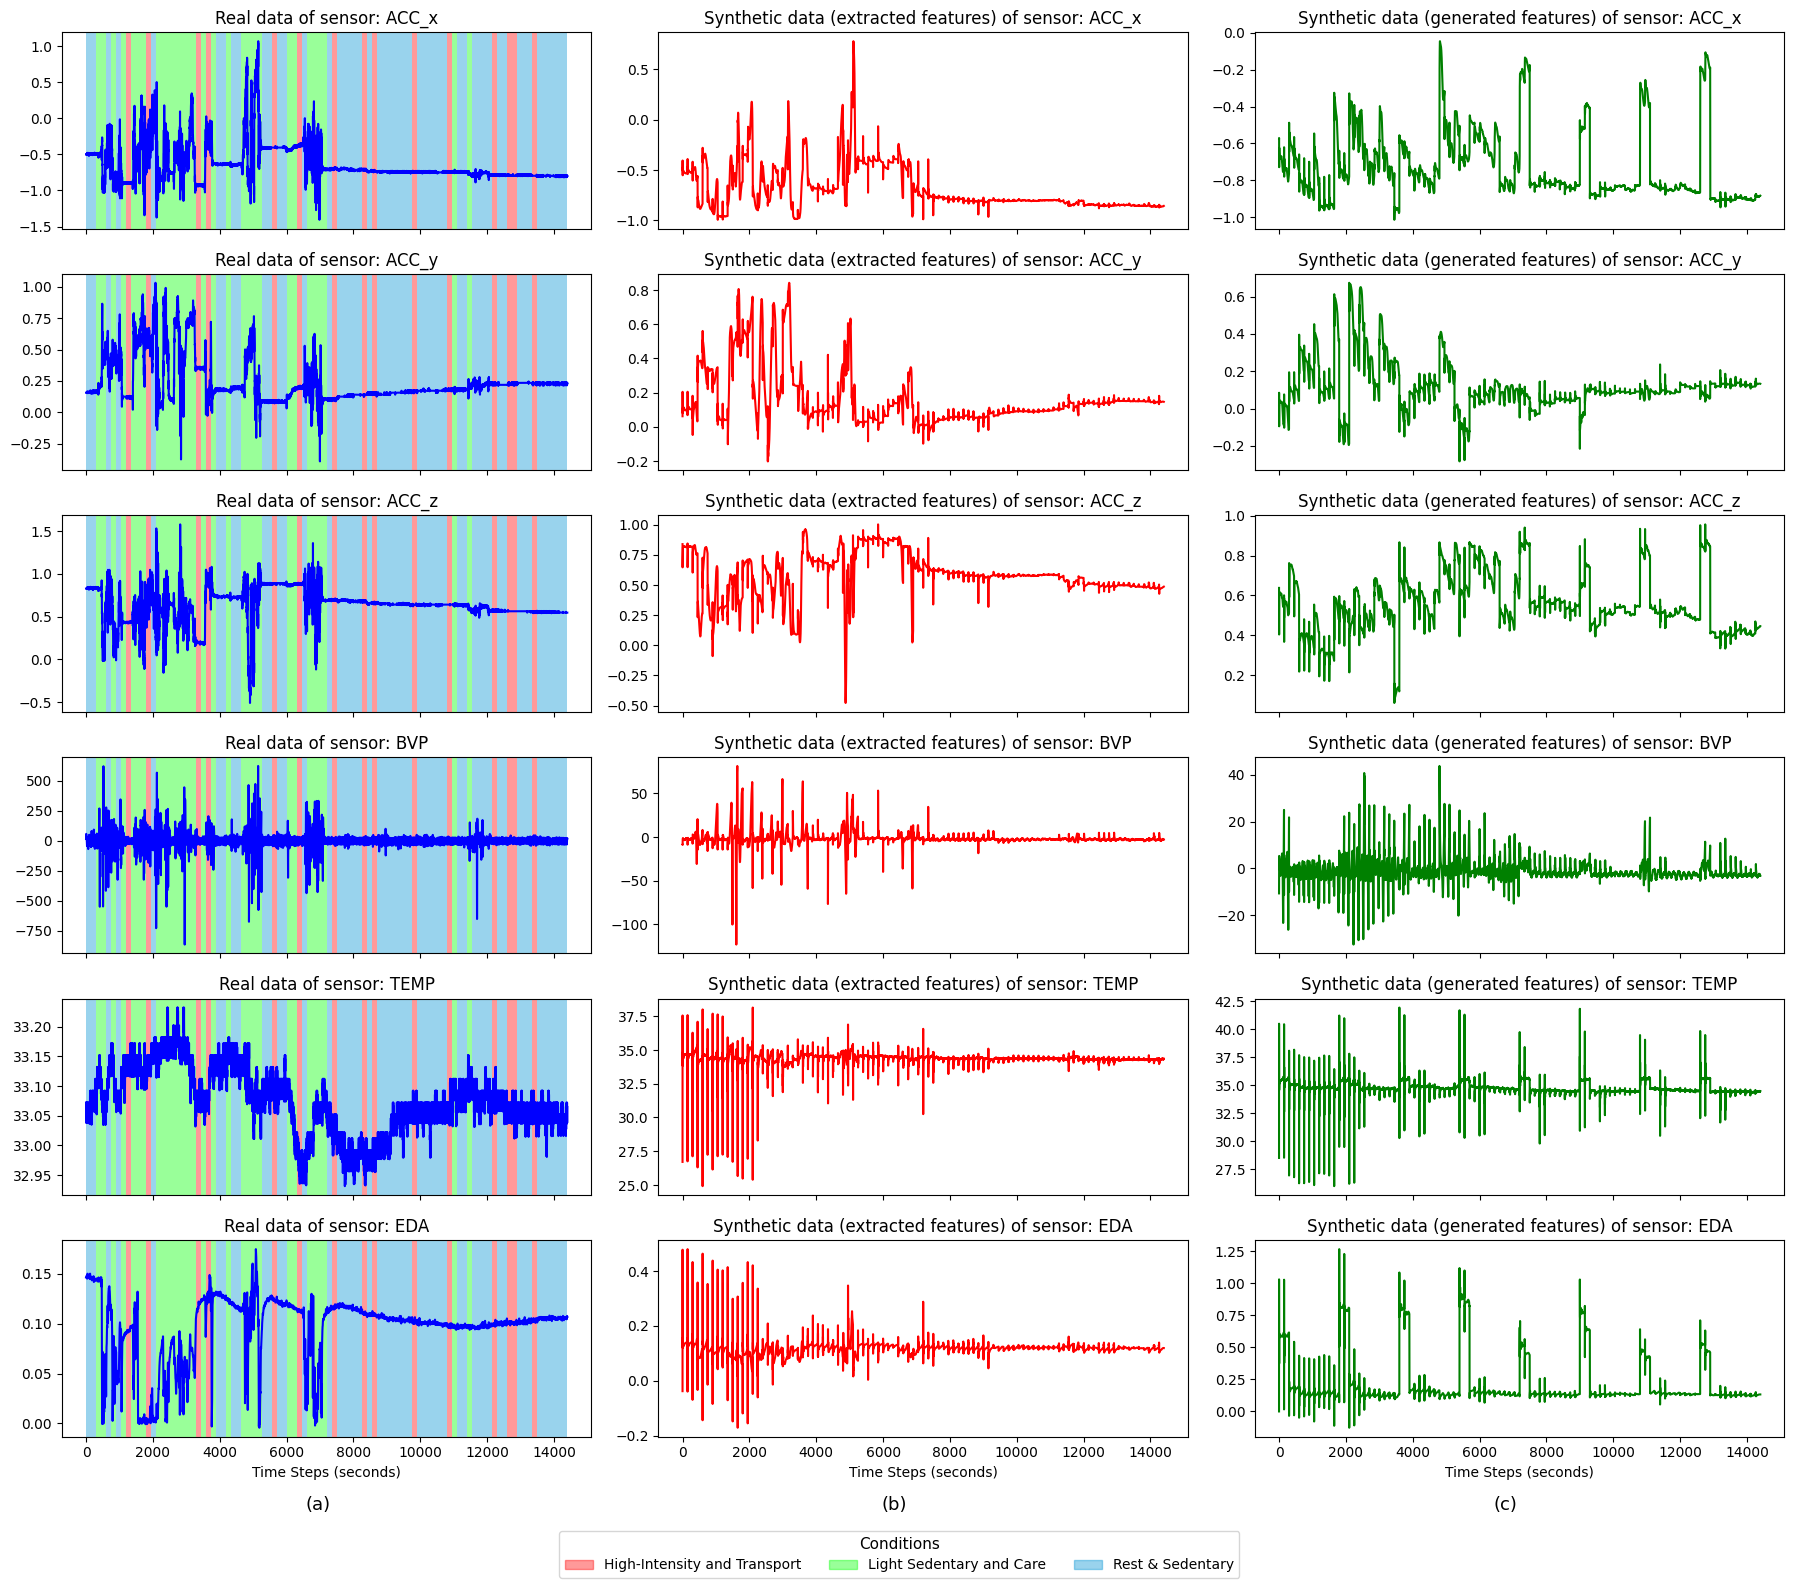

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import groupby

# Colors and labels for each condition
# condition_colors  = ["#FF61B0", "#4ED08F", "#9E5FFE",
#                      "#FDFD59", "#FF587A", "#8783FF"]

# condition_colors = [
#     '#D32F2F',  # deep red
#     '#388E3C',  # dark green
#     '#1976D2',  # medium blue
#     '#FBC02D',  # mustard yellow
#     '#7B1FA2',  # purple
#     '#00796B'   # teal
# ]

condition_colors = [
    '#FF0000',  # blue
    "#18DAA6",  # turquoise-green
    '#000088',  # orange
    '#00FF00',  # green
    '#0093D3',  # red
    "#FFA000"   # teal
]

condition_labels  = [
    'High-Intensity and Transport', 
    'Hiking & Walking', 
    'Household & Light Manual',
    'Light Sedentary and Care', 
    'Rest & Sedentary', 
    'Walking Activities Across Contexts'
    ]

# Sensor labels
sensor_names = ['ACC_x', 'ACC_y', 'ACC_z', 'BVP', 'TEMP', 'EDA']

# Figure: 6 rows × 3 columns
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 15))
axes = axes.flatten()

# ───────────────────────────────────────────
# 2.  DRAW BACKGROUND ONLY ON LEFT COLUMN
# ───────────────────────────────────────────
# Left‑column axes are 0, 3, 6, … → index % 3 == 0
left_column_axes = [ax for idx, ax in enumerate(axes) if idx % 3 == 0]

for ax in left_column_axes:
    for k, g in groupby(enumerate(condition_indices), key=lambda x: x[1]):
        g = list(g)
        start = g[0][0]
        end   = g[-1][0] + 1
        ax.axvspan(start, end,
                   color=condition_colors[k],
                   alpha=0.4, linewidth=0)

# ───────────────────────────────────────────
# 3.  PLOT THE THREE DATA SERIES
# ───────────────────────────────────────────
for i in range(6):
    sensor_name = sensor_names[i]

    # Real data (left)
    axes[i * 3].plot(data[0, i, :],  color='b')
    axes[i * 3].set_title(f'Real data of sensor: {sensor_name}')

    # Autoencoder output (middle)
    axes[i * 3 + 1].plot(rdsi[0, i, :], color='r')
    axes[i * 3 + 1].set_title(f'Synthetic data (extracted features) of sensor: {sensor_name}')

    # Scenario‑to‑synthetic (right)
    axes[i * 3 + 2].plot(rsdsi[0, i, :], color='g')
    axes[i * 3 + 2].set_title(f'Synthetic data (generated features) of sensor: {sensor_name}')

# ───────────────────────────────────────────
# 4.  AXIS FORMATTING
# ───────────────────────────────────────────
for ax in axes[:-3]:     # hide x ticks for all but last row
    ax.set_xticklabels([])
    ax.set_xlabel('')

for ax in axes[-3:]:     # label bottom row
    ax.set_xlabel('Time Steps (seconds)', fontsize=10)

# ───────────────────────────────────────────
# 5.  LEGEND ON FIRST SUBPLOT ONLY
# ───────────────────────────────────────────
selected_indicies = [0,3,4]

# legend_patches = [mpatches.Patch(color=condition_colors[i],
#                                  label=condition_labels[i],
#                                  alpha=0.4)
#                   for i in range(len(condition_colors))]

legend_patches = [mpatches.Patch(color=condition_colors[i],
                                 label=condition_labels[i],
                                 alpha=0.4)
                  for i in selected_indicies]


# axes[0].legend(handles=legend_patches,
#                loc='upper right',
#                bbox_to_anchor=(1.05, 1.0),
#                title='Conditions',
#                fontsize=9,
#                title_fontsize=10,
#                frameon=True)

# Add legend to the entire figure below all subplots
fig.legend(
    handles=legend_patches,
    loc='lower center',
    ncol=3,              # Spread across columns
    bbox_to_anchor=(0.5, -0.06),  # Centered below the figure
    fontsize=10,
    title='Conditions',
    title_fontsize=11,
    frameon=True
)

# ───────────────────────────────────────────
# 6.  SAVE / SHOW
# ───────────────────────────────────────────
plt.tight_layout()

# Add column labels (a), (b), (c) below the x-axis
fig.text(0.17, -0.01, '(a)', fontsize=13)  # Left column
fig.text(0.49, -0.01, '(b)', fontsize=13)  # Middle column
fig.text(0.83, -0.01, '(c)', fontsize=13)  # Right column

# plt.savefig("output_3_colored.pdf", dpi=600, bbox_inches='tight')
# plt.savefig("output_3_colored.png", dpi=600, bbox_inches='tight')
plt.savefig("output_3_colored_300_dpi.png", dpi=300, bbox_inches='tight')
plt.show()


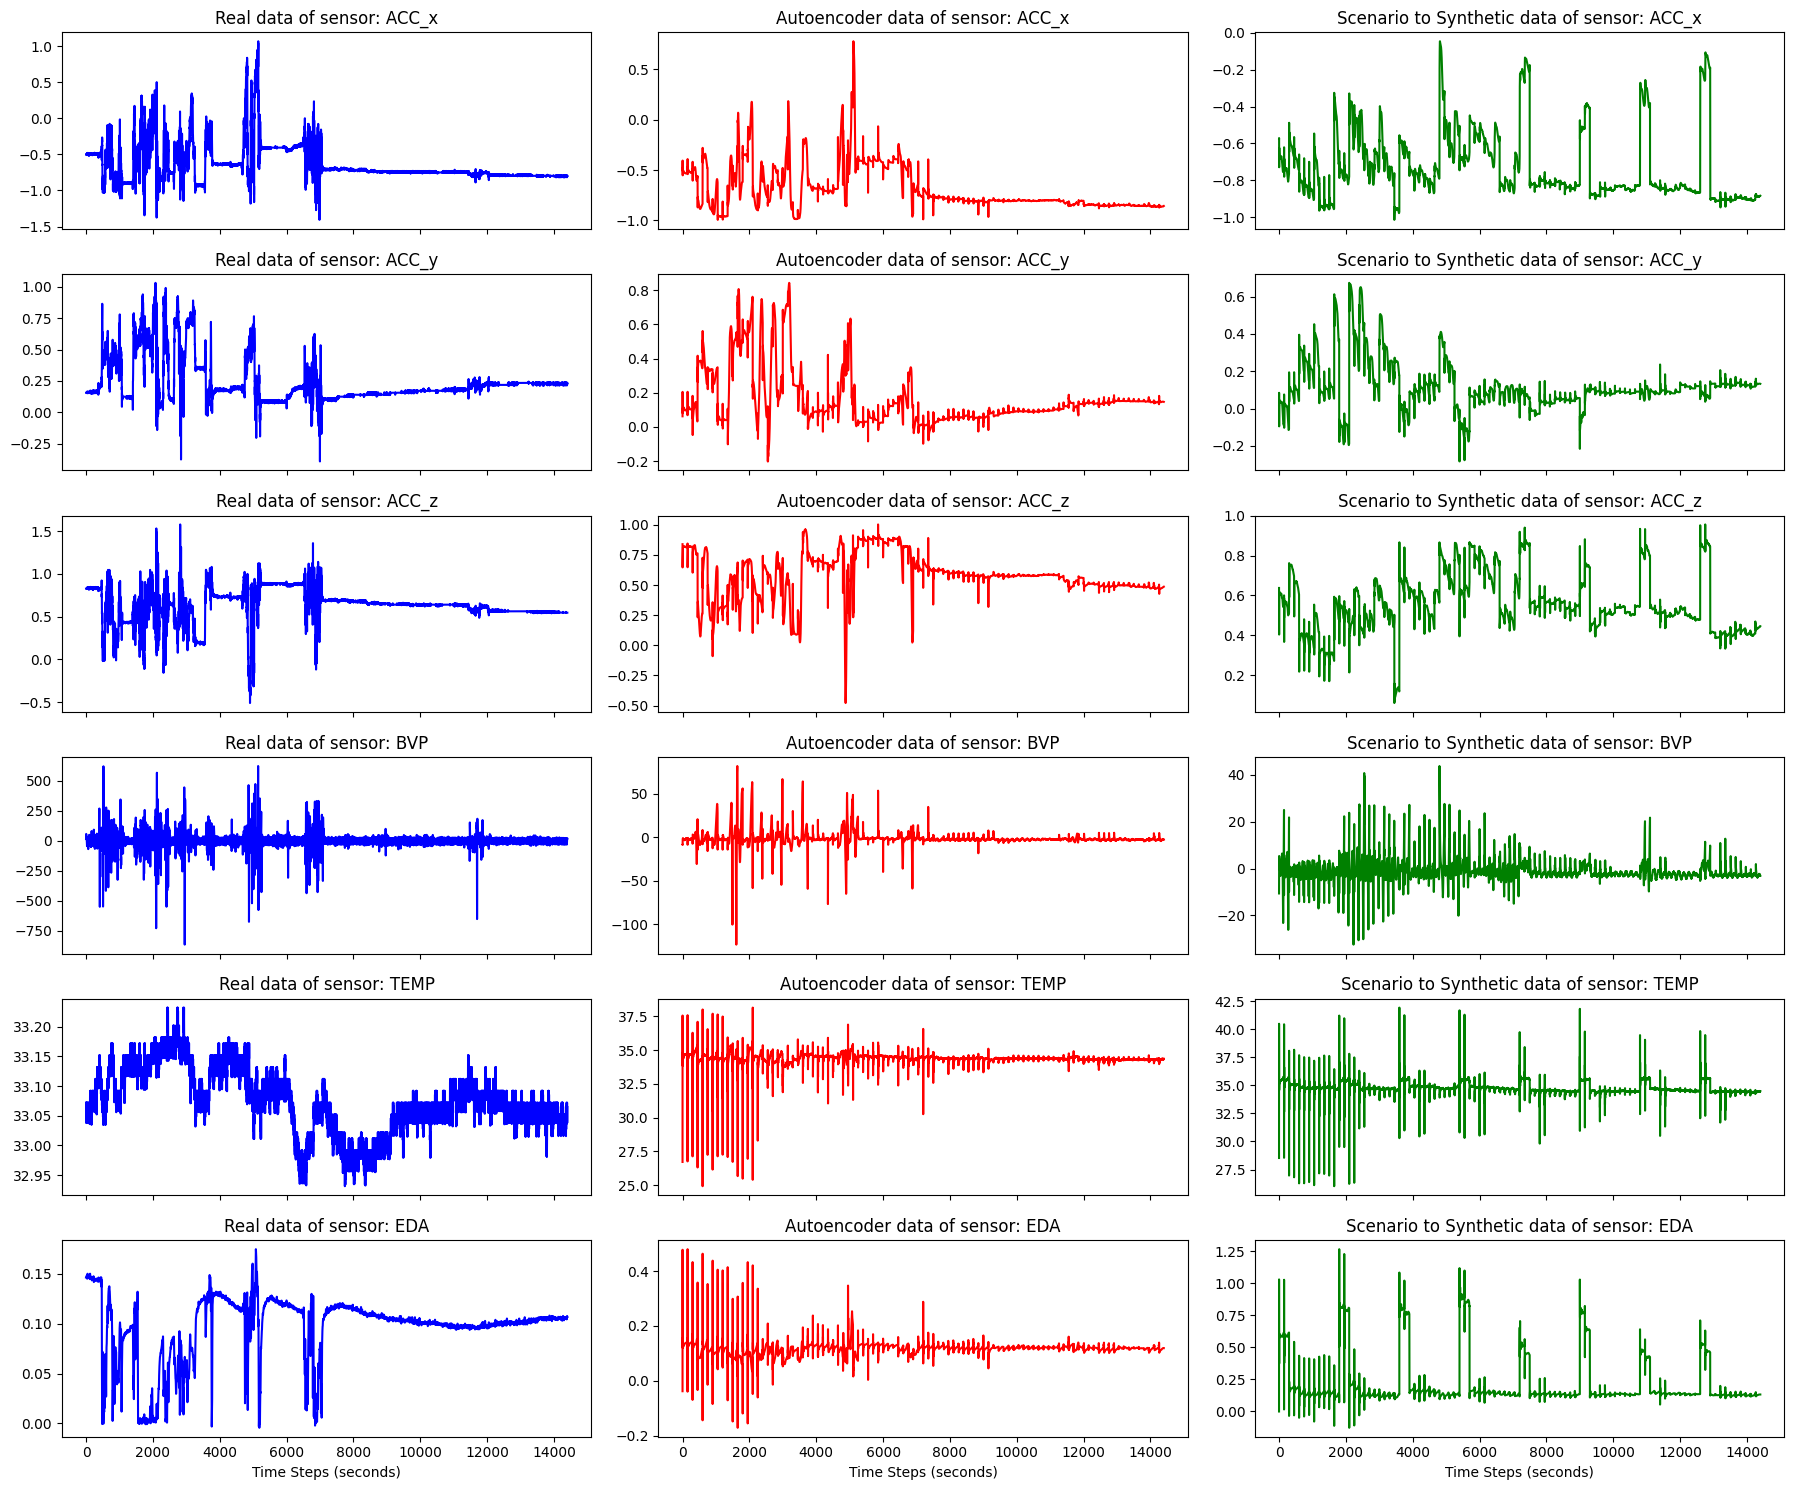

In [ ]:
# Define sensor names
sensor_names = ['ACC_x', 'ACC_y', 'ACC_z', 'BVP', 'TEMP', 'EDA']

# Create a figure with 6 rows and 3 columns
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 15))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot in each subplot
for i in range(6):
    sensor_name = sensor_names[i]
    
    axes[i * 3].plot(data[0, i, :], color='b', label=sensor_name)  # Left column
    axes[i * 3].set_title(f'Real data of sensor: {sensor_name}')
    
    axes[i * 3 + 1].plot(rdsi[0, i, :], color='r', label=sensor_name)  # Mid column
    axes[i * 3 + 1].set_title(f'Autoencoder data of sensor: {sensor_name}')
    
    axes[i * 3 + 2].plot(rsdsi[0, i, :], color='g', label=sensor_name)  # Right column
    axes[i * 3 + 2].set_title(f'Scenario to Synthetic data of sensor: {sensor_name}')

# Hide x-axis tick labels and labels for all but the last row
for ax in axes[:-3]:
    ax.set_xticklabels([])
    ax.set_xlabel('')

# Set x-axis labels for the bottom row only
for ax in axes[-3:]:
    ax.set_xlabel('Time Steps (seconds)', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.savefig("output_3.pdf", dpi=600, bbox_inches='tight')
plt.show()
